## Equipment Failure Anomaly Detection
This workbook utilizes an autoencoder neural network to detect vibrational anomalies in sensor readings from bearings, aiming to predict potential bearing failures before they occur. The vibrational data is sourced from NASA's Acoustics and Vibration Database. Each dataset comprises individual files representing 1-second vibration signal snapshots, recorded at 10-minute intervals. These files contain 20,480 data points per snapshot, collected at a sampling rate of 20 kHz from the bearing sensors.

The autoencoder model is built using Long Short-Term Memory (LSTM) recurrent neural network (RNN) cells, implemented with the Keras/TensorFlow framework.

In [1]:
# import libraries
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import joblib

import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.random import seed
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.logging.set_verbosity(tf.logging.ERROR)


from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers
from keras.optimizers import Adam


2024-11-17 10:43:40.469171: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-17 10:43:40.469266: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-17 10:43:40.511705: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-17 10:43:40.607443: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-17 10:43:41.833010: W tensorflow/compiler/tf2

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
# set random seed
seed(10)
tf.set_random_seed(10)

# Data loading and pre-processing
It is assumed that mechanical degradation in the bearings develops gradually over time. To account for this, the analysis uses one data point every 10 minutes. Each 10-minute data point is calculated as the mean absolute value of the vibration readings from the 20,480 data points in each file. All the data points are then combined into a single dataframe for analysis.

In [3]:
# Load, average, and merge sensor samples
sensor_data_path = 'data/bearing_data'
aggregated_sensor_data = pd.DataFrame()

for file_name in os.listdir(sensor_data_path):
    vibration_data = pd.read_csv(os.path.join(sensor_data_path, file_name), sep='\t')
    mean_abs_vibration = np.array(vibration_data.abs().mean())
    mean_abs_vibration = pd.DataFrame(mean_abs_vibration.reshape(1, 4))
    mean_abs_vibration.index = [file_name]
    aggregated_sensor_data = pd.concat([aggregated_sensor_data, mean_abs_vibration])
    
aggregated_sensor_data.columns = ['Bearing_1', 'Bearing_2', 'Bearing_3', 'Bearing_4']


In [4]:
# Transform data file index to datetime and sort in chronological order
aggregated_sensor_data.index = pd.to_datetime(aggregated_sensor_data.index, format='%Y.%m.%d.%H.%M.%S')
aggregated_sensor_data = aggregated_sensor_data.sort_index()
aggregated_sensor_data.to_csv('Averaged_BearingTest_Dataset.csv')
print("Dataset shape:", aggregated_sensor_data.shape)
aggregated_sensor_data.head()


Dataset shape: (982, 4)


,Bearing_1,Bearing_2,Bearing_3,Bearing_4
2004-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443
2004-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081
2004-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118
2004-02-12 11:22:39,0.061665,0.073279,0.084879,0.044172
2004-02-12 11:32:39,0.061944,0.074593,0.082626,0.044659


# Define train/test data
Before setting up the models, we need to define train/test data. To do this, we perform a simple split where we train on the first part of the dataset (which should represent normal operating conditions) and test on the remaining parts of the dataset leading up to the bearing failure.

In [5]:
training_data = aggregated_sensor_data['2004-02-12 10:52:39': '2004-02-15 12:52:39']
testing_data = aggregated_sensor_data['2004-02-15 12:52:39':]
print("Training dataset shape:", training_data.shape)
print("Test dataset shape:", testing_data.shape)


Training dataset shape: (445, 4)
Test dataset shape: (538, 4)


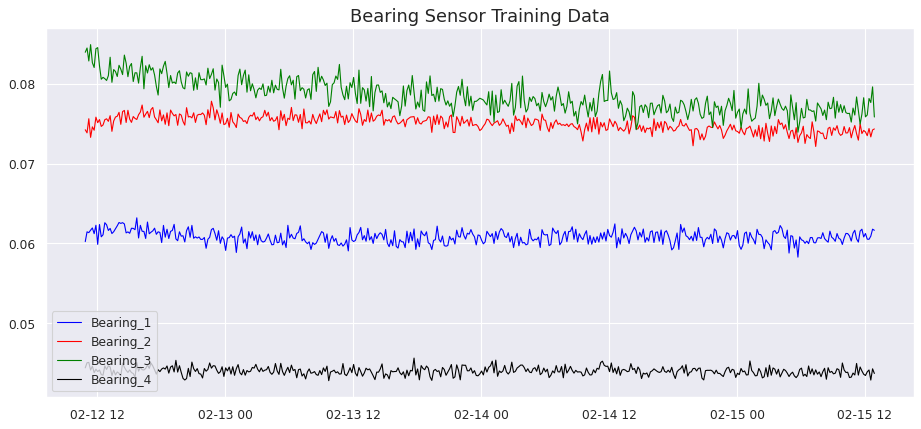

In [6]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(training_data['Bearing_1'], label='Bearing_1', color='blue', animated=True, linewidth=1)
ax.plot(training_data['Bearing_2'], label='Bearing_2', color='red', animated=True, linewidth=1)
ax.plot(training_data['Bearing_3'], label='Bearing_3', color='green', animated=True, linewidth=1)
ax.plot(training_data['Bearing_4'], label='Bearing_4', color='black', animated=True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Bearing Sensor Training Data', fontsize=16)
plt.show()


Let’s get a different perspective of the data by transforming the signal from the time domain to the frequency domain using a discrete Fourier transform.

In [7]:
# Transforming data from the time domain to the frequency domain using Fast Fourier Transform
training_data_fft = np.fft.fft(training_data)
testing_data_fft = np.fft.fft(testing_data)


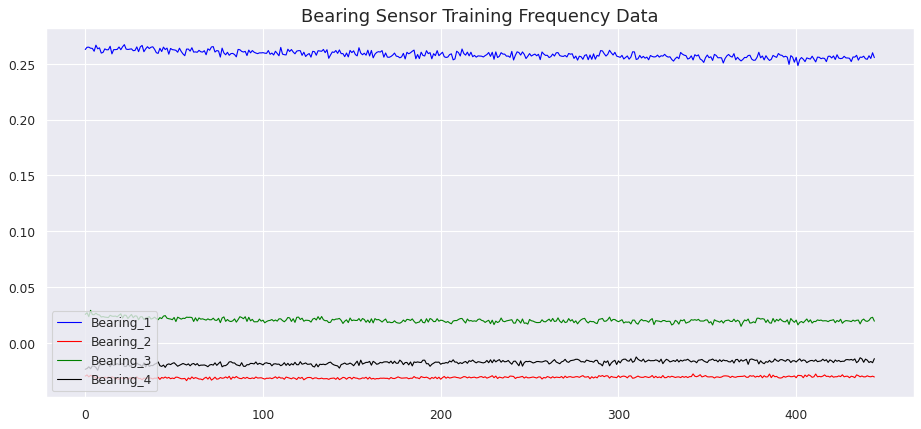

In [8]:
# Frequencies of the healthy sensor signal
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(training_data_fft[:, 0].real, label='Bearing_1', color='blue', animated=True, linewidth=1)
ax.plot(training_data_fft[:, 1].imag, label='Bearing_2', color='red', animated=True, linewidth=1)
ax.plot(training_data_fft[:, 2].real, label='Bearing_3', color='green', animated=True, linewidth=1)
ax.plot(training_data_fft[:, 3].real, label='Bearing_4', color='black', animated=True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Bearing Sensor Training Frequency Data', fontsize=16)
plt.show()

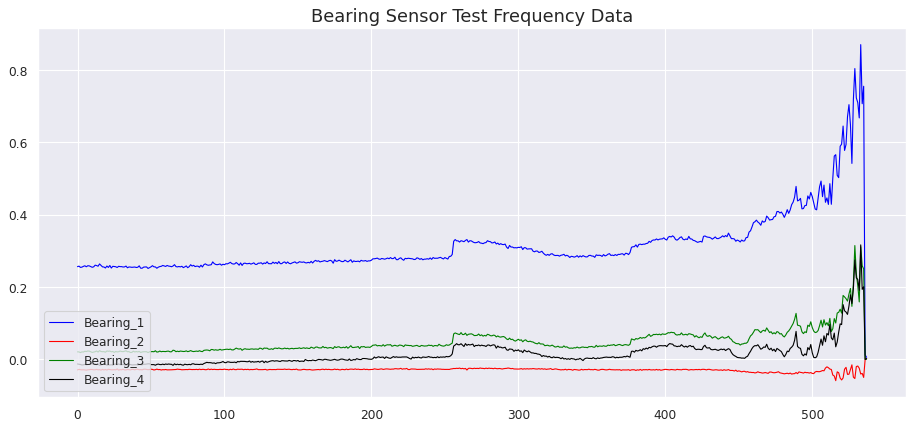

In [9]:
# Frequencies of the degrading sensor signal
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(testing_data_fft[:, 0].real, label='Bearing_1', color='blue', animated=True, linewidth=1)
ax.plot(testing_data_fft[:, 1].imag, label='Bearing_2', color='red', animated=True, linewidth=1)
ax.plot(testing_data_fft[:, 2].real, label='Bearing_3', color='green', animated=True, linewidth=1)
ax.plot(testing_data_fft[:, 3].real, label='Bearing_4', color='black', animated=True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Bearing Sensor Test Frequency Data', fontsize=16)
plt.show()

In [10]:
# Normalize the data
scaler = MinMaxScaler()
X_training_data = scaler.fit_transform(training_data)
X_testing_data = scaler.transform(testing_data)
scaler_filename = "scaler_data"
joblib.dump(scaler, scaler_filename)


['scaler_data']

In [11]:
# Reshape inputs for LSTM [samples, timesteps, features]
X_training_data = X_training_data.reshape(X_training_data.shape[0], 1, X_training_data.shape[1])
print("Training data shape:", X_training_data.shape)
X_testing_data = X_testing_data.reshape(X_testing_data.shape[0], 1, X_testing_data.shape[1])
print("Test data shape:", X_testing_data.shape)

Training data shape: (445, 1, 4)
Test data shape: (538, 1, 4)


In [12]:
# Define the autoencoder network model
def autoencoder_network(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(16, activation='relu', return_sequences=True,
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    return model


In [13]:
# Create the autoencoder model
model = autoencoder_network(X_training_data)
model.compile(optimizer='adam', loss='mae')
model.summary()

2024-11-17 10:51:04.075870: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-17 10:51:04.232338: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-17 10:51:04.232414: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-17 10:51:04.235403: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-17 10:51:04.235476: I external/local_xla/xla/stream_executor

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 4)]            0         
                                                                 
 lstm (LSTM)                 (None, 1, 16)             1344      
                                                                 
 lstm_1 (LSTM)               (None, 4)                 336       
                                                                 
 repeat_vector (RepeatVecto  (None, 1, 4)              0         
 r)                                                              
                                                                 
 lstm_2 (LSTM)               (None, 1, 4)              144       
                                                                 
 lstm_3 (LSTM)               (None, 1, 16)             1344      
                                                             

In [21]:
# fit the model to the data
nb_epochs = 100
batch_size = 10
history = model.fit(X_training_data, X_training_data, epochs=nb_epochs, batch_size=batch_size,
                    validation_split=0.05).history

Train on 422 samples, validate on 23 samples
Epoch 1/100


2024-11-17 11:19:25.889934: W tensorflow/core/framework/op_kernel.cc:1827] UNKNOWN: JIT compilation failed.
2024-11-17 11:19:25.890116: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12710466892165142107
2024-11-17 11:19:25.890138: W tensorflow/core/framework/op_kernel.cc:1827] UNKNOWN: JIT compilation failed.


UnknownError: 2 root error(s) found.
  (0) UNKNOWN: JIT compilation failed.
	 [[{{node training/Adam/Pow}}]]
	 [[loss/AddN/_137]]
  (1) UNKNOWN: JIT compilation failed.
	 [[{{node training/Adam/Pow}}]]
0 successful operations.
0 derived errors ignored.

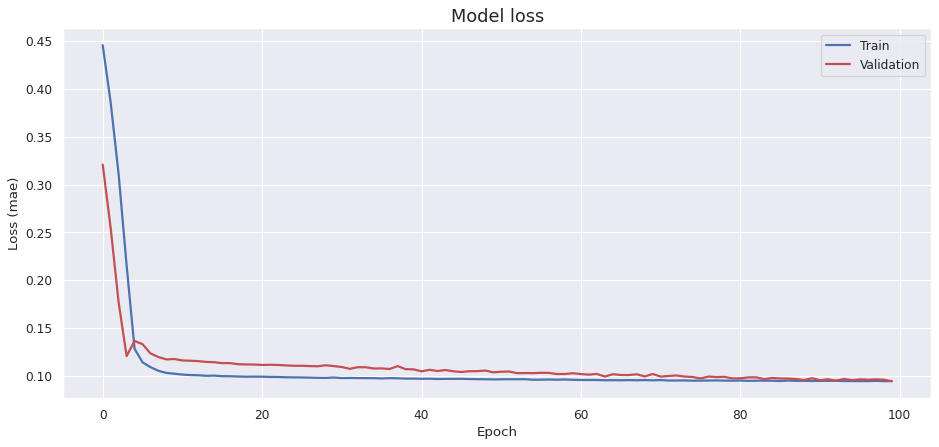

In [19]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

# Distribution of Loss Function
By plotting the distribution of the calculated loss in the training set, one can use this to identify a suitable threshold value for identifying an anomaly. In doing this, one can make sure that this threshold is set above the “noise level” and that any flagged anomalies should be statistically significant above the background noise.

/home/swalgo/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
2024-11-10 17:12:33.070319: W tensorflow/c/c_api.cc:300] Operation '{name:'time_distributed/Reshape_1' id:670 op device:{requested: '', assigned: ''} def:{{{node time_distributed/Reshape_1}} = Reshape[T=DT_FLOAT, Tshape=DT_INT32, _has_manual_control_dependencies=true](time_distributed/dense/BiasAdd, time_distributed/Reshape_1/shape)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/tmp/ipykernel_823108/3269023118.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function w

(0.0, 0.5)

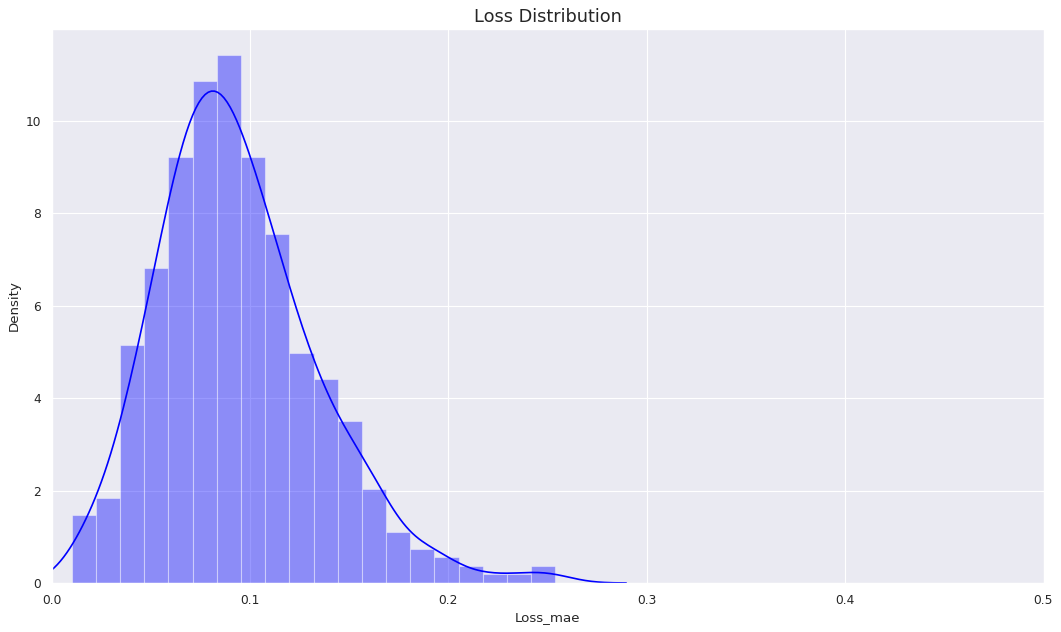

In [20]:
# plot the loss distribution of the training set
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=train.columns)
X_pred.index = train.index

scored = pd.DataFrame(index=train.index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis = 1)
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mae'], bins = 20, kde= True, color = 'blue');
plt.xlim([0.0,.5])

From the above loss distribution, let's try a threshold value of 0.275 for flagging an anomaly. We can then calculate the loss in the test set to check when the output crosses the anomaly threshold.

In [21]:
# calculate the loss on the test set
X_pred = model.predict(X_test)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=test.columns)
X_pred.index = test.index

scored = pd.DataFrame(index=test.index)
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtest), axis = 1)
scored['Threshold'] = 0.275
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored.head()

,Loss_mae,Threshold,Anomaly
2004-02-15 12:52:39,0.092594,0.275,False
2004-02-15 13:02:39,0.179607,0.275,False
2004-02-15 13:12:39,0.058303,0.275,False
2004-02-15 13:22:39,0.055329,0.275,False
2004-02-15 13:32:39,0.043237,0.275,False


In [22]:
# calculate the same metrics for the training set 
# and merge all data in a single dataframe for plotting
X_pred_train = model.predict(X_train)
X_pred_train = X_pred_train.reshape(X_pred_train.shape[0], X_pred_train.shape[2])
X_pred_train = pd.DataFrame(X_pred_train, columns=train.columns)
X_pred_train.index = train.index

scored_train = pd.DataFrame(index=train.index)
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-Xtrain), axis = 1)
scored_train['Threshold'] = 0.275
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
scored = pd.concat([scored_train, scored])

Having calculated the loss distribution and the anomaly threshold, we can visualize the model output in the time leading up to the bearing failure.

<AxesSubplot:>

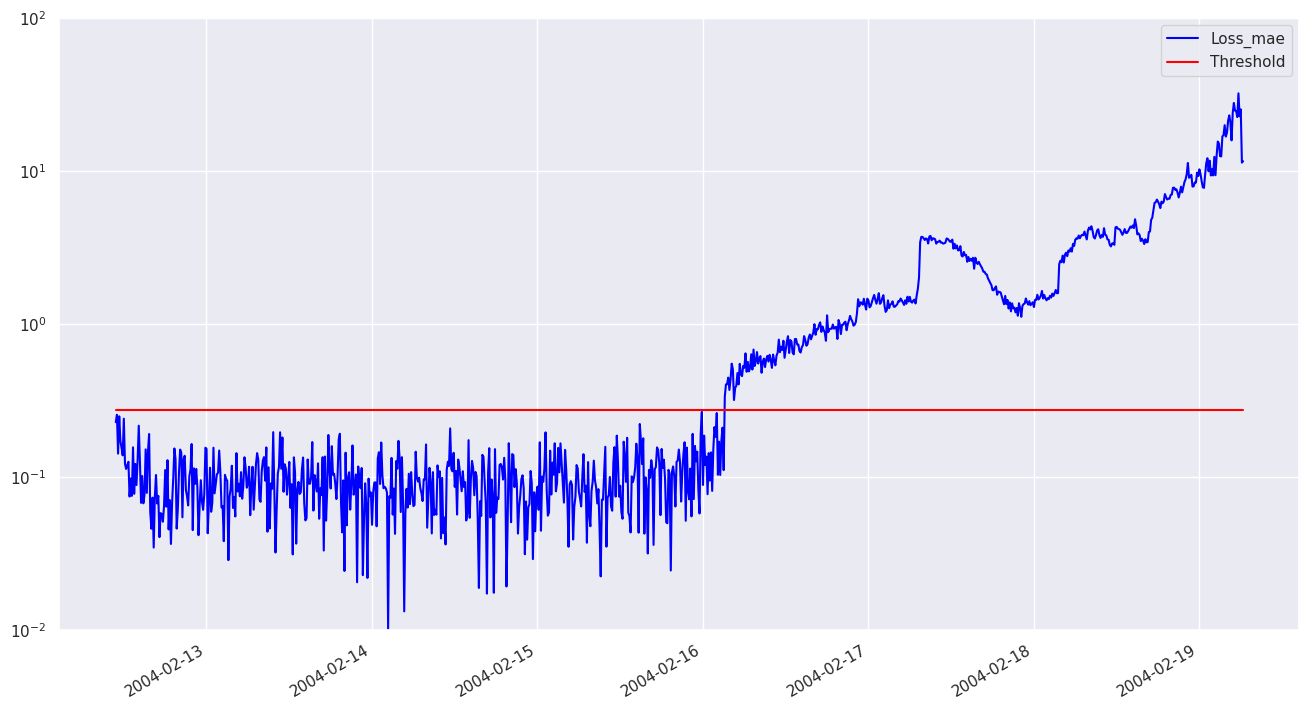

In [23]:
# plot bearing failure time plot
scored.plot(logy=True,  figsize=(16,9), ylim=[1e-2,1e2], color=['blue','red'])

This analysis approach is able to flag the upcoming bearing malfunction well in advance of the actual physical failure. It is important to define a suitable threshold value for flagging anomalies while avoiding too many false positives during normal operating conditions.

In [24]:
# save all model information, including weights, in h5 format
model.save("Cloud_model.h5")
print("Model saved")

Model saved
